<a href="https://colab.research.google.com/github/WalidYaser/Deep-Learning/blob/main/walid_yasser_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

جاري تحميل البيانات من Francesco/bone-fracture-7fylg...

--- (VGG16 Architecture) ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Custom_Dense_ReLU (Dense)       │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Regularization          │ (None, 256)            │             0 │
│ (Dropout)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Sigmoid (Dense)          │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

-----------------------------------------

جاري بدء عملية التدريب باستخدام VGG16...
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - accuracy: 0.8348 - loss: 13.6591 - val_accuracy: 0.9688 - val_loss: 6.3970
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - accuracy: 0.9612 - loss: 5.2721 - val_accuracy: 0.9688 - val_loss: 0.5147
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.8779 - loss: 1.5579 - val_accuracy: 0.9688 - val_loss: 0.5950
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.9766 - loss: 0.6497 - val_accuracy: 0.9688 - val_loss: 0.6979
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.9657 - loss: 0.3903 - val_accuracy: 0.9688 - val_loss: 0.1892
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.8971 - loss: 0.3752 - val_accuracy: 0.9062 - val_loss: 0.1959
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 0.9546 - loss: 0.3125 - val_accuracy: 0.9375 - val_loss: 0.1562
Epoch 8/15
10/10 ━━

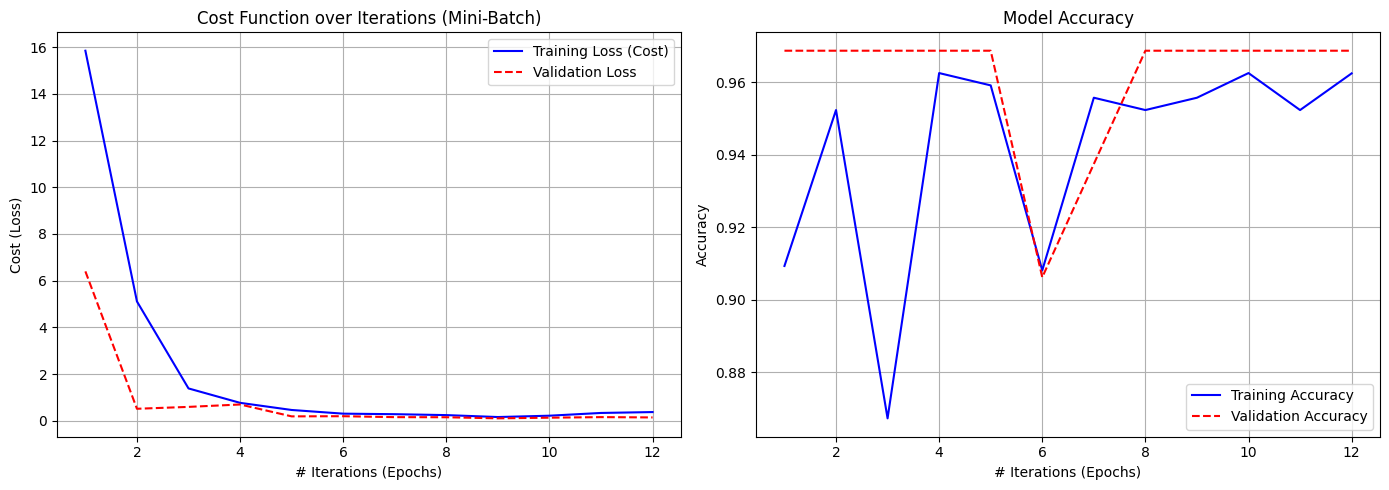

In [3]:
import tensorflow as tf
from datasets import load_dataset
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, RandomFlip, RandomRotation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

hf_dataset_path = "Francesco/bone-fracture-7fylg"
print(f"جاري تحميل البيانات من {hf_dataset_path}...")
dataset = load_dataset(hf_dataset_path)

train_data = dataset['train']
val_data = dataset['validation']

def preprocess_image(element):
    image = element['image']
    objects = element['objects']


    label = 1 if len(objects['category']) > 0 else 0

    if image.mode != 'RGB':
        image = image.convert('RGB')


    image = tf.image.resize(tf.keras.preprocessing.image.img_to_array(image), [224, 224])


    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

def gen_train():
    for ex in train_data: yield preprocess_image(ex)

def gen_val():
    for ex in val_data: yield preprocess_image(ex)

output_sig = (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
              tf.TensorSpec(shape=(), dtype=tf.int64))


batch_size = 32
train_ds = tf.data.Dataset.from_generator(gen_train, output_signature=output_sig).batch(batch_size).repeat()
val_ds = tf.data.Dataset.from_generator(gen_val, output_signature=output_sig).batch(batch_size).repeat()

steps_per_epoch = max(1, len(train_data) // batch_size)
validation_steps = max(1, len(val_data) // batch_size)

# ==========================================
# 2.(VGG16 & Transfer Learning)
# ==========================================

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
], name="Data_Augmentation")

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)

x = Flatten(name="Flatten_Layer")(x)

x = Dense(256, activation='relu', name="Custom_Dense_ReLU")(x)

x = Dropout(0.5, name="Dropout_Regularization")(x)

outputs = Dense(1, activation='sigmoid', name="Output_Sigmoid")(x)

model = Model(inputs, outputs)

print("\n--- (VGG16 Architecture) ---")
model.summary()
print("-----------------------------------------\n")

# ==========================================
# 3. (Optimization)
# ==========================================
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ==========================================
# 4.(Early Stopping)
# ==========================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("جاري بدء عملية التدريب باستخدام VGG16...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
print("تم التدريب بنجاح!")

# ==========================================
# 5. (Cost Function Curve)
# ==========================================
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, 'b-', label='Training Loss (Cost)')
    plt.plot(epochs_range, val_loss, 'r--', label='Validation Loss')
    plt.title('Cost Function over Iterations (Mini-Batch)')
    plt.xlabel('# Iterations (Epochs)')
    plt.ylabel('Cost (Loss)')
    plt.legend()
    plt.grid(True)

    #(Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, 'r--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('# Iterations (Epochs)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("جاري رسم منحنيات الأداء...")

plot_learning_curve(history)